<a href="https://colab.research.google.com/github/akileswaran/mould-box-distance-measurement-projcet/blob/main/Distance_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# USAGE
# python distance_between.py --image images/example_01.png --width 0.955
# python distance_between.py --image images/example_02.png --width 0.955
# python distance_between.py --image images/example_03.png --width 3.5

# import the necessary packages
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

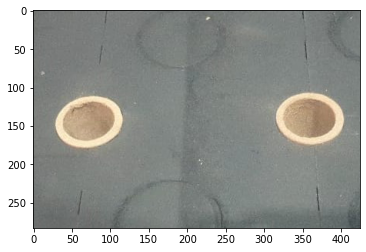

In [2]:
image = cv2.imread('photo.jpg')
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img = mpimg.imread('photo.jpg')
plt.imshow(img)

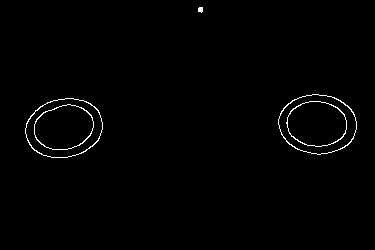

In [21]:
# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread('photo.jpg')
r = 250.0 / image.shape[0]
dim = (int(image.shape[1] * r), 250)
image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (9, 9), 0)
# cv2_imshow(gray)
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)
# edged = medfilt2(edged,[10 10],'symmetric'); 
cv2_imshow(edged)

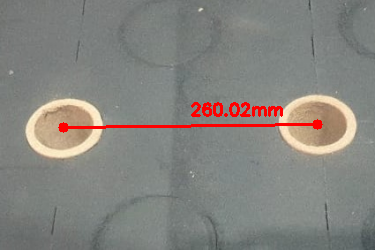

In [23]:
# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread('photo.jpg')
r = 250.0 / image.shape[0]
dim = (int(image.shape[1] * r), 250)
image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)
# edged = medfilt2(edged,[10 10],'symmetric'); 
#cv2_imshow(edged)
# find contours in the edge map
cnts,a = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

#cnts = cnts[0] #if imutils.is_cv2() else cnts[1]
# print (cnts)
# sort the contours from left-to-right and, then initialize the
# distance colors and reference object
(cnts, _) = contours.sort_contours(cnts, method='right-to-left')
colors = ((0, 0, 255), (240, 0, 159), (0, 165, 255), (255, 255, 0),
	(255, 0, 255))
refObj = None
#print(cnts)

# loop over the contours individually
for c in cnts:
  # if the contour is not sufficiently large, ignore it
  if cv2.contourArea(c) < 100:
    continue
  # compute the rotated bounding box of the contour
  box = cv2.minAreaRect(c)
  # print(box)
  box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
  box = np.array(box, dtype="int")
  #print(box)
  
  # order the points in the contour such that they appear
  # in top-left, top-right, bottom-right, and bottom-left
  # order, then draw the outline of the rotated bounding
  # box
  box = perspective.order_points(box)
  
  # compute the center of the bounding box
  cX = np.average(box[:, 0])
  cY = np.average(box[:, 1])
  
  # if this is the first contour we are examining (i.e.,
  # the left-most contour), we presume this is the
  # reference object
  if refObj is None:
    # unpack the ordered bounding box, then compute the
    # midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-right and
    # bottom-right
    (tl, tr, br, bl) = box
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)
    
    # compute the Euclidean distance between the midpoints,
    # then construct the reference object
    D = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
    refObj = (box, (cX, cY), D / 80)
    continue
  # draw the contours on the image
  orig = image.copy()
  # one = cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
  # two = cv2.drawContours(orig, [refObj[0].astype("int")], -1, (0, 255, 0), 2)
  
  
  # stack the reference coordinates and the object coordinates
  # to include the object center
  refCoords = np.vstack([refObj[1]])
  objCoords = np.vstack([(cX, cY)])
  #print (refCoords)
  
  # loop over the original points
  for ((xA, yA), (xB, yB), color) in zip(refCoords, objCoords, colors):
    # draw circles corresponding to the current points and
    # connect them with a line
    cv2.circle(orig, (int(xA), int(yA)), 5, color, -1)
    cv2.circle(orig, (int(xB), int(yB)), 5, color, -1)
    cv2.line(orig, (int(xA), int(yA)), (int(xB), int(yB)),
             color, 2)
    # compute the Euclidean distance between the coordinates,
    # and then convert the distance in pixels to distance in
    # units
    D = dist.euclidean((xA, yA), (xB, yB)) / refObj[2]
    (mX, mY) = midpoint((xA, yA), (xB, yB))
    cv2.putText(orig, "{:.2f}mm".format(D), (int(mX), int(mY - 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)
    # show the output image
    cv2_imshow(orig)
    cv2.waitKey(0)


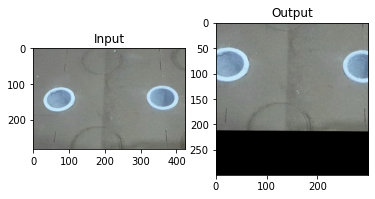

In [ ]:
img = cv2.imread('dist.jpeg')
rows,cols,ch = img.shape

pts1 = np.float32([[56,65],[368,52],[28,387],[389,390]])
pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])

M = cv2.getPerspectiveTransform(pts1,pts2)

dst = cv2.warpPerspective(img,M,(300,300))

plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  # load the image, convert it to grayscale, and blur it slightly
  image =filename
  r = 1000.0 / image.shape[0]
  dim = (int(image.shape[1] * r), 1000)
  image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (7, 7), 0)

  # perform edge detection, then perform a dilation + erosion to
  # close gaps in between object edges
  edged = cv2.Canny(gray, 50, 100)
  edged = cv2.dilate(edged, None, iterations=1)
  edged = cv2.erode(edged, None, iterations=1)
  # edged = medfilt2(edged,[10 10],'symmetric'); 
  #cv2_imshow(edged)
  # find contours in the edge map
  cnts,a = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

  #cnts = cnts[0] #if imutils.is_cv2() else cnts[1]
  # print (cnts)
  # sort the contours from left-to-right and, then initialize the
  # distance colors and reference object
  (cnts, _) = contours.sort_contours(cnts, method='right-to-left')
  colors = ((0, 0, 255), (240, 0, 159), (0, 165, 255), (255, 255, 0),
    (255, 0, 255))
  refObj = None
  #print(cnts)

  # loop over the contours individually
  for c in cnts:
    # if the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 100:
      continue
    # compute the rotated bounding box of the contour
    box = cv2.minAreaRect(c)
    # print(box)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    #print(box)
    
    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    box = perspective.order_points(box)
    
    # compute the center of the bounding box
    cX = np.average(box[:, 0])
    cY = np.average(box[:, 1])
    
    # if this is the first contour we are examining (i.e.,
    # the left-most contour), we presume this is the
    # reference object
    if refObj is None:
      # unpack the ordered bounding box, then compute the
      # midpoint between the top-left and top-right points,
      # followed by the midpoint between the top-right and
      # bottom-right
      (tl, tr, br, bl) = box
      (tlblX, tlblY) = midpoint(tl, bl)
      (trbrX, trbrY) = midpoint(tr, br)
      
      # compute the Euclidean distance between the midpoints,
      # then construct the reference object
      D = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
      refObj = (box, (cX, cY), D / 21)
      continue
    # draw the contours on the image
    orig = image.copy()
    # one = cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
    # two = cv2.drawContours(orig, [refObj[0].astype("int")], -1, (0, 255, 0), 2)
    
    
    # stack the reference coordinates and the object coordinates
    # to include the object center
    refCoords = np.vstack([refObj[1]])
    objCoords = np.vstack([(cX, cY)])
    #print (refCoords)
    
    # loop over the original points
    for ((xA, yA), (xB, yB), color) in zip(refCoords, objCoords, colors):
      # draw circles corresponding to the current points and
      # connect them with a line
      cv2.circle(orig, (int(xA), int(yA)), 5, color, -1)
      cv2.circle(orig, (int(xB), int(yB)), 5, color, -1)
      cv2.line(orig, (int(xA), int(yA)), (int(xB), int(yB)),
              color, 2)
      # compute the Euclidean distance between the coordinates,
      # and then convert the distance in pixels to distance in
      # units
      D = dist.euclidean((xA, yA), (xB, yB)) / refObj[2]
      (mX, mY) = midpoint((xA, yA), (xB, yB))
      cv2.putText(orig, "{:.2f}mm".format(D), (int(mX), int(mY - 10)),
                  cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)
      # show the output image
      cv2_imshow(orig)
      cv2.waitKey(0)
    print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored